In [1]:
import polars as pl
from loguru import logger
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np
from pathlib import Path

In [2]:
def get_topic_colors(topics):
    """Assign green to 'Climate Change', others get non-green tab20 colors."""
    palette = sns.color_palette('tab20', len(topics) + 1)
    green = "#2ca02c"  # Matplotlib green
    green_rgb = mcolors.to_rgb(green)
    non_green_palette = [c for c in palette if mcolors.to_rgb(c) != green_rgb]
    colors = {}
    for topic in topics:
        if topic == "Climate change":
            colors[topic] = green
        else:
            colors[topic] = mcolors.to_hex(non_green_palette.pop(0))
    return colors

def aggregate_by_month(df, date_col='date', group_cols=None):
    """Aggregate DataFrame by month and group columns."""
    if group_cols is None:
        group_cols = []
    df = df.with_columns([
        pl.col(date_col).cast(str).str.slice(0, 7).alias('month')
    ])
    return df.group_by(['month'] + group_cols).len().sort('month')

def explode(df, col):
    """Explode a list column and drop nulls."""
    return df.explode(col).drop_nulls(col)

def top_k_values(df, col, k):
    """Get top k values from a column by count."""
    return (
        explode(df, col)
        .group_by(col)
        .len()
        .sort("len", descending=True)
        .head(k)[col]
        .to_list()
    )

In [3]:
FILE_DIR = Path.cwd()
combined_path = FILE_DIR.parent / r"data\blogs_articles\combined_parsed_ecb_articles.parquet"
combined_df = pl.read_parquet(combined_path)
dev_df = combined_df.filter(pl.col('filter_type') == 'topic')
df = dev_df
topic_col = 'filter_value'
top_topics = top_k_values(df, topic_col, 20)
top_authors = top_k_values(df, 'authors', 20)
topic_colors = get_topic_colors(top_topics)

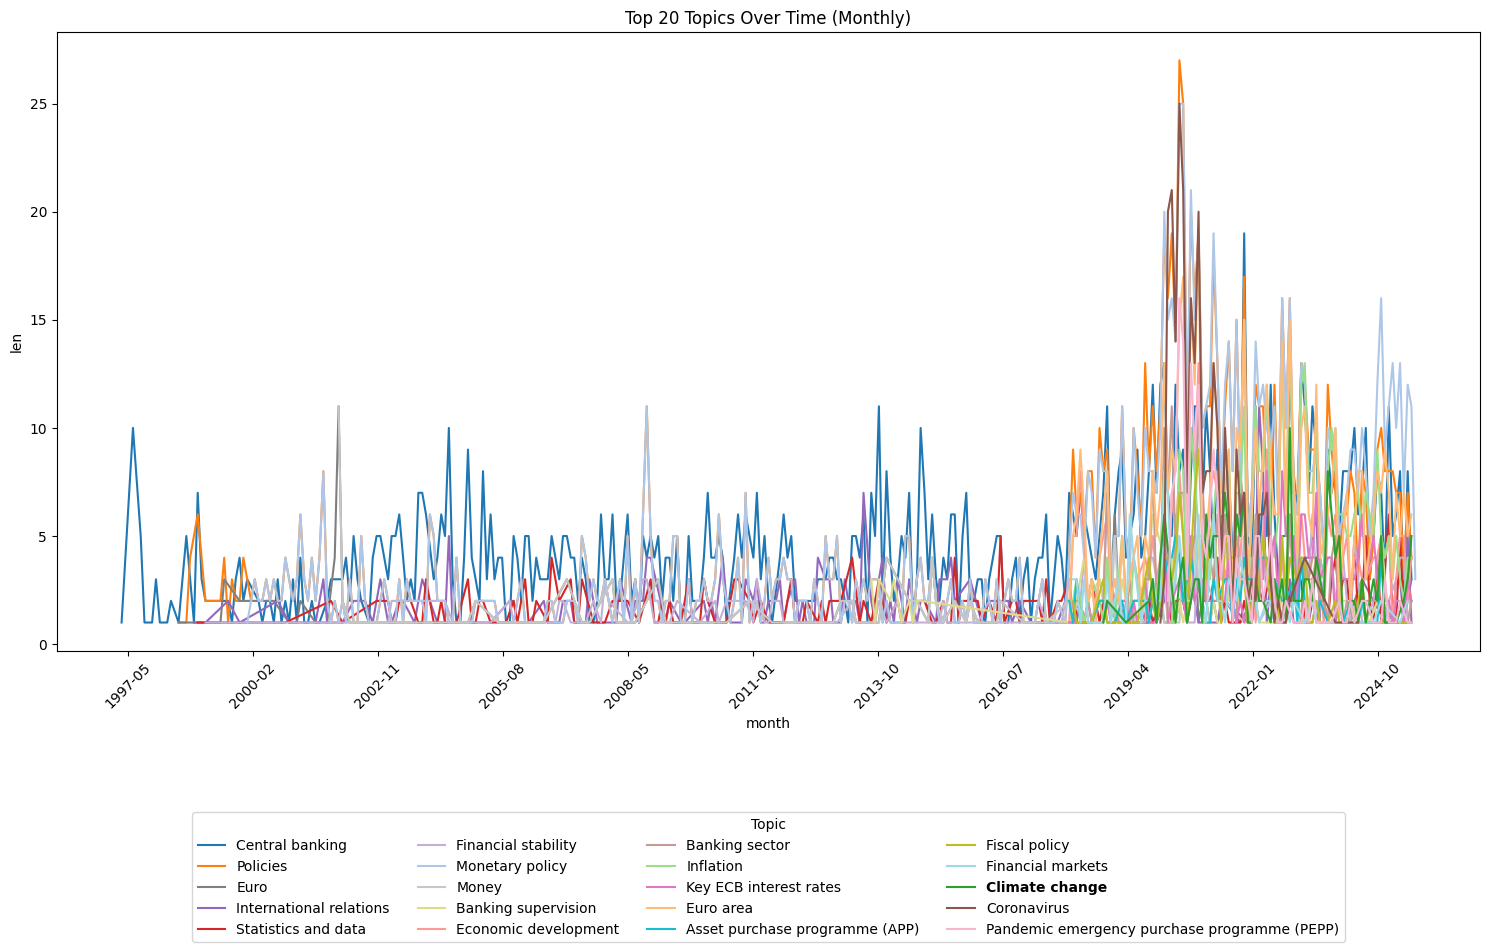

In [4]:
def plot_topics_over_time(df, topic_col, top_topics, topic_colors):
    df_exploded = explode(df, topic_col)
    df_exploded = df_exploded.filter(pl.col(topic_col).is_in(top_topics))
    df_monthly = aggregate_by_month(df_exploded, date_col='date', group_cols=[topic_col])
    pdf = df_monthly.to_pandas()
    pdf['month'] = pd.to_datetime(pdf['month'], format='%Y-%m')
    plt.figure(figsize=(15,10))
    ax = sns.lineplot(data=pdf, x="month", y="len", hue=topic_col, palette=topic_colors)
    plt.title("Top 20 Topics Over Time (Monthly)")
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    # Make 'Climate change' bold in legend
    leg = ax.legend(title="Topic", loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4)
    for text in leg.get_texts():
        if text.get_text() == 'Climate change':
            text.set_fontweight('bold')
    plt.tight_layout()
    plt.show()

plot_topics_over_time(df, topic_col, top_topics, topic_colors)


C:\Users\povhi\AppData\Local\Temp\ipykernel_3152\2551442414.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=pdf, x="len", y=topic_col, palette=topic_colors)


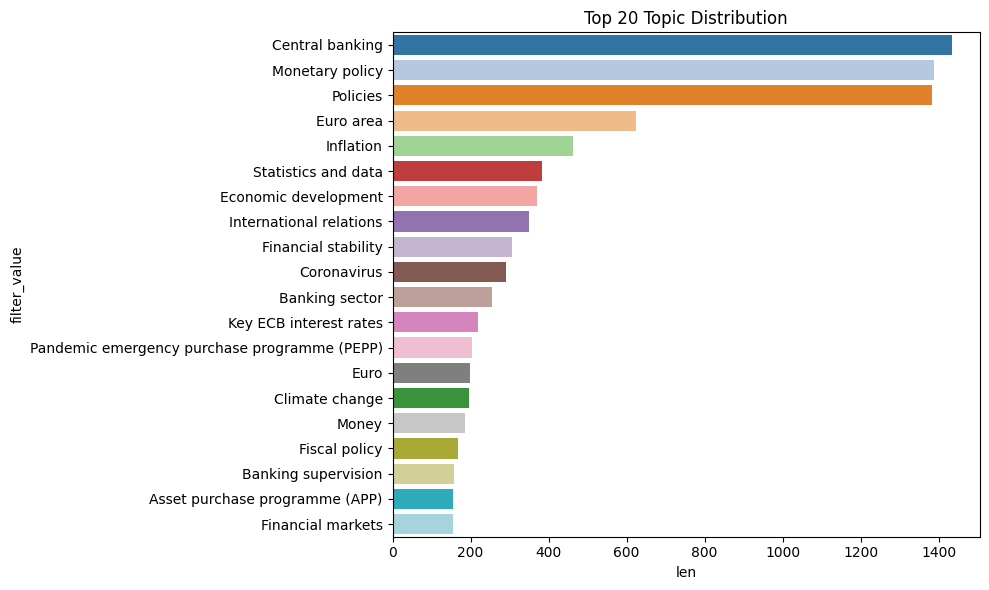

In [5]:
def plot_topic_distribution(df, topic_col, top_topics, topic_colors):
    topic_dist = (
        explode(df, topic_col)
        .group_by(topic_col)
        .len()
        .sort("len", descending=True)
        .head(len(top_topics))
    )
    pdf = topic_dist.to_pandas()
    plt.figure(figsize=(10,6))
    ax = sns.barplot(data=pdf, x="len", y=topic_col, palette=topic_colors)
    plt.title("Top 20 Topic Distribution")
    # Move legend below plot
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(title="Topic", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    plt.tight_layout()
    plt.show()

plot_topic_distribution(df, topic_col, top_topics, topic_colors)


C:\Users\povhi\AppData\Local\Temp\ipykernel_3152\2716388589.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=pdf, y=topic_col, order=top_topics, palette=topic_colors)
C:\Users\povhi\AppData\Local\Temp\ipykernel_3152\2716388589.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = ax.legend(title="Topic", loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4)


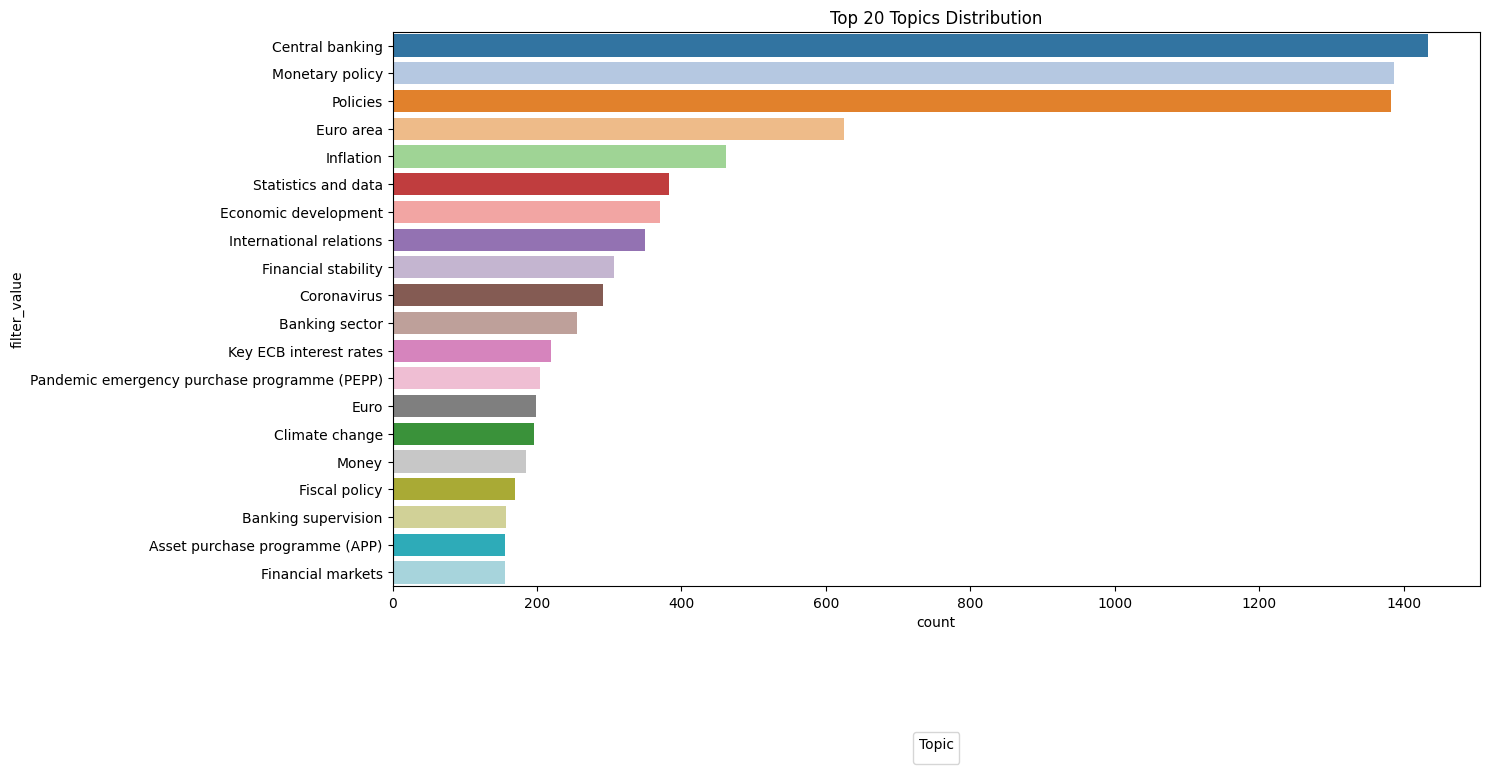

In [6]:
def plot_topic_distribution(df, topic_col, top_topics, topic_colors):
    df_exploded = explode(df, topic_col)
    df_exploded = df_exploded.filter(pl.col(topic_col).is_in(top_topics))
    pdf = df_exploded.to_pandas()
    plt.figure(figsize=(15,8))
    ax = sns.countplot(data=pdf, y=topic_col, order=top_topics, palette=topic_colors)
    plt.title("Top 20 Topics Distribution")
    # Make 'Climate change' bold in legend
    leg = ax.legend(title="Topic", loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4)
    for text in leg.get_texts():
        if text.get_text() == 'Climate change':
            text.set_fontweight('bold')
    plt.tight_layout()
    plt.show()

plot_topic_distribution(df, topic_col, top_topics, topic_colors)


C:\Users\povhi\AppData\Local\Temp\ipykernel_3152\2397372131.py:8: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivot = topics_category.pivot(
C:\Users\povhi\AppData\Local\Temp\ipykernel_3152\2397372131.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


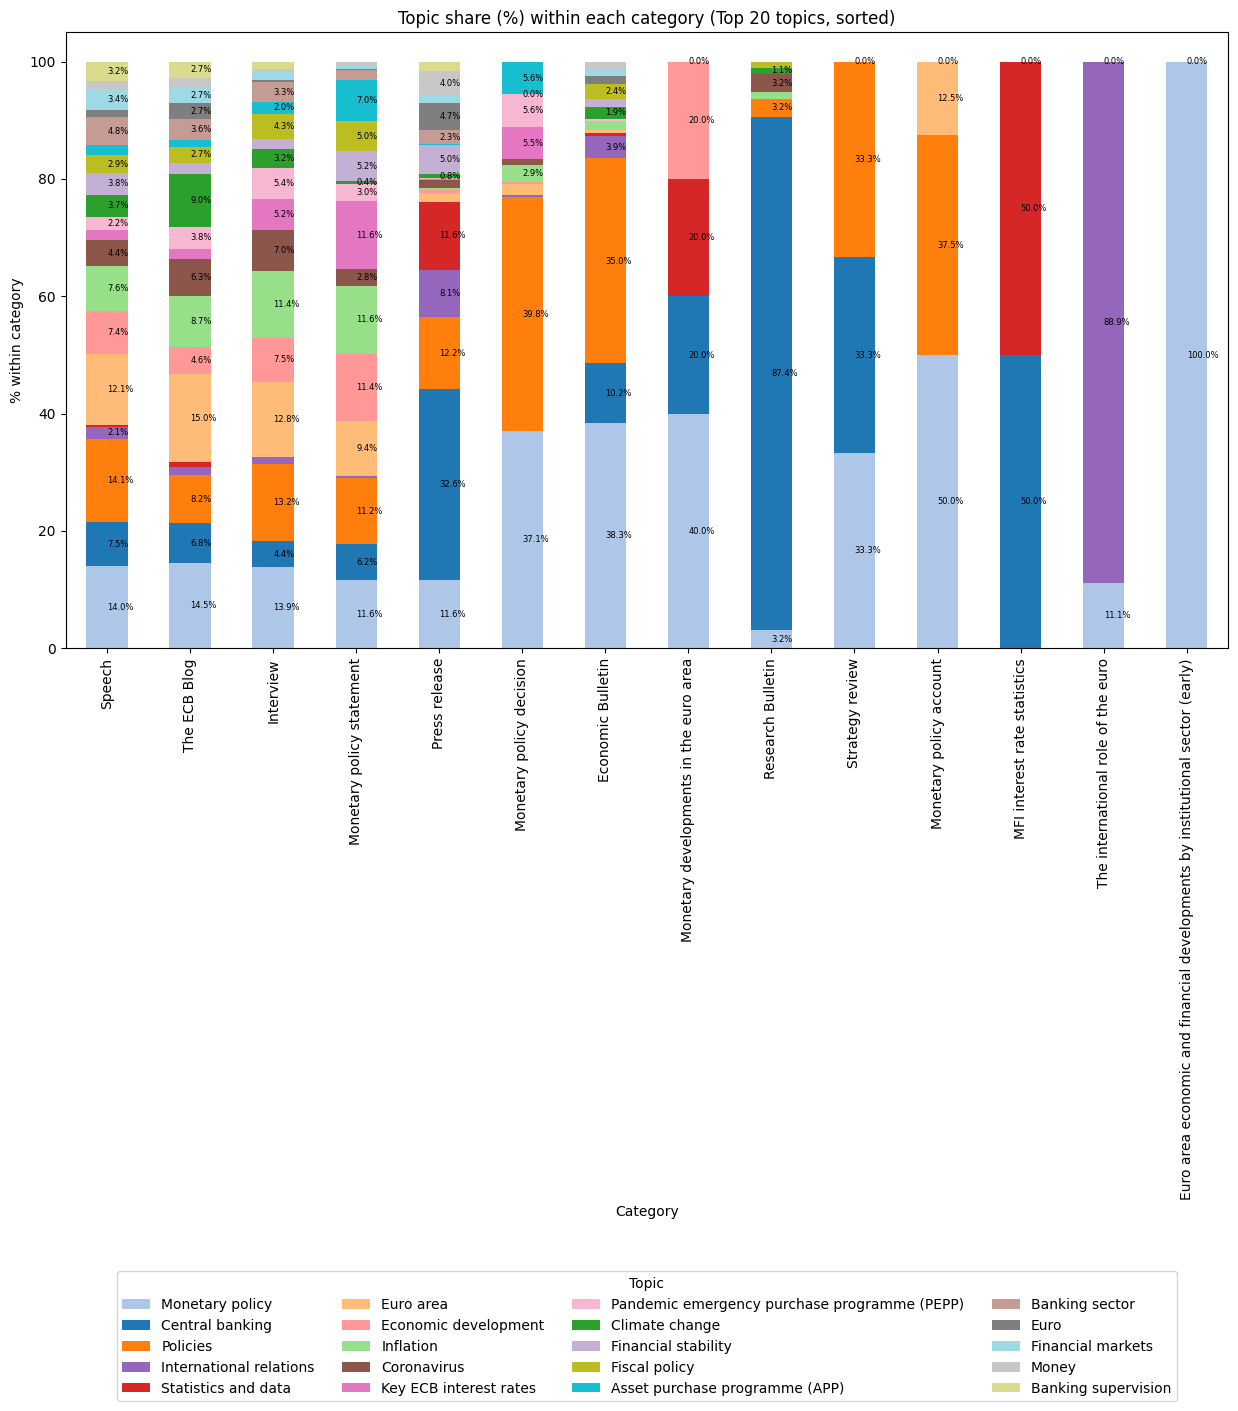

In [7]:
def plot_topics_by_category_stackedbar(df, topic_col, top_topics, topic_colors):
    topics_category = (
        explode(df, topic_col)
        .filter(pl.col(topic_col).is_in(top_topics))
        .group_by(["category_base", topic_col])
        .len()
    )
    pivot = topics_category.pivot(
        values="len", index="category_base", columns=topic_col
    ).fill_null(0)
    num_cols = [c for c in pivot.columns if c != "category_base"]
    perc_pivot = (
        pivot
        .with_columns(row_sum=pl.sum_horizontal(pl.all().exclude("category_base")))
        .with_columns([
            (pl.col(c) / pl.col("row_sum") * 100).alias(c) for c in num_cols
        ])
        .drop("row_sum")
    )
    pdf = perc_pivot.to_pandas().set_index("category_base")
    sorted_cols = (
        pdf.mean(axis=0)
        .sort_values(ascending=False)
        .index.tolist()
    )
    # Count number of topics >2% per category
    topic_counts = (pdf[sorted_cols] > 2).sum(axis=1)
    # Sort categories by this count (descending)
    pdf_sorted = pdf[sorted_cols].loc[topic_counts.sort_values(ascending=False).index]
    ax = pdf_sorted.plot(
        kind="bar", stacked=True, figsize=(15, 8), color=[topic_colors[t] for t in sorted_cols]
    )
    ax.set_ylabel("% within category")
    ax.set_xlabel("Category")
    ax.set_title("Topic share (%) within each category (Top 20 topics, sorted)")
    for c_idx, category in enumerate(pdf_sorted.index):
        cum = 0
        for t_idx, topic in enumerate(sorted_cols):
            val = pdf_sorted.loc[category, topic]
            if val > 2 or topic == 'Climate change':
                cum += val
                ax.text(
                    c_idx, cum - val/2, f"{val:.1f}%", 
                    ha='left', va='center', fontsize=6, color='black', rotation=0, clip_on=True
                )
            else:
                cum += val
    # Move legend below plot
    ax.legend(title="Topic", bbox_to_anchor=(0.5, -1), loc="upper center", ncol=4)
    plt.tight_layout()
    plt.show()

plot_topics_by_category_stackedbar(df, topic_col, top_topics, topic_colors)


C:\Users\povhi\AppData\Local\Temp\ipykernel_3152\2756042113.py:9: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  co_df = pl.DataFrame(co_occ, schema=["t1", "t2"])
C:\Users\povhi\AppData\Local\Temp\ipykernel_3152\2756042113.py:19: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(values="count", index="t1", columns="t2")


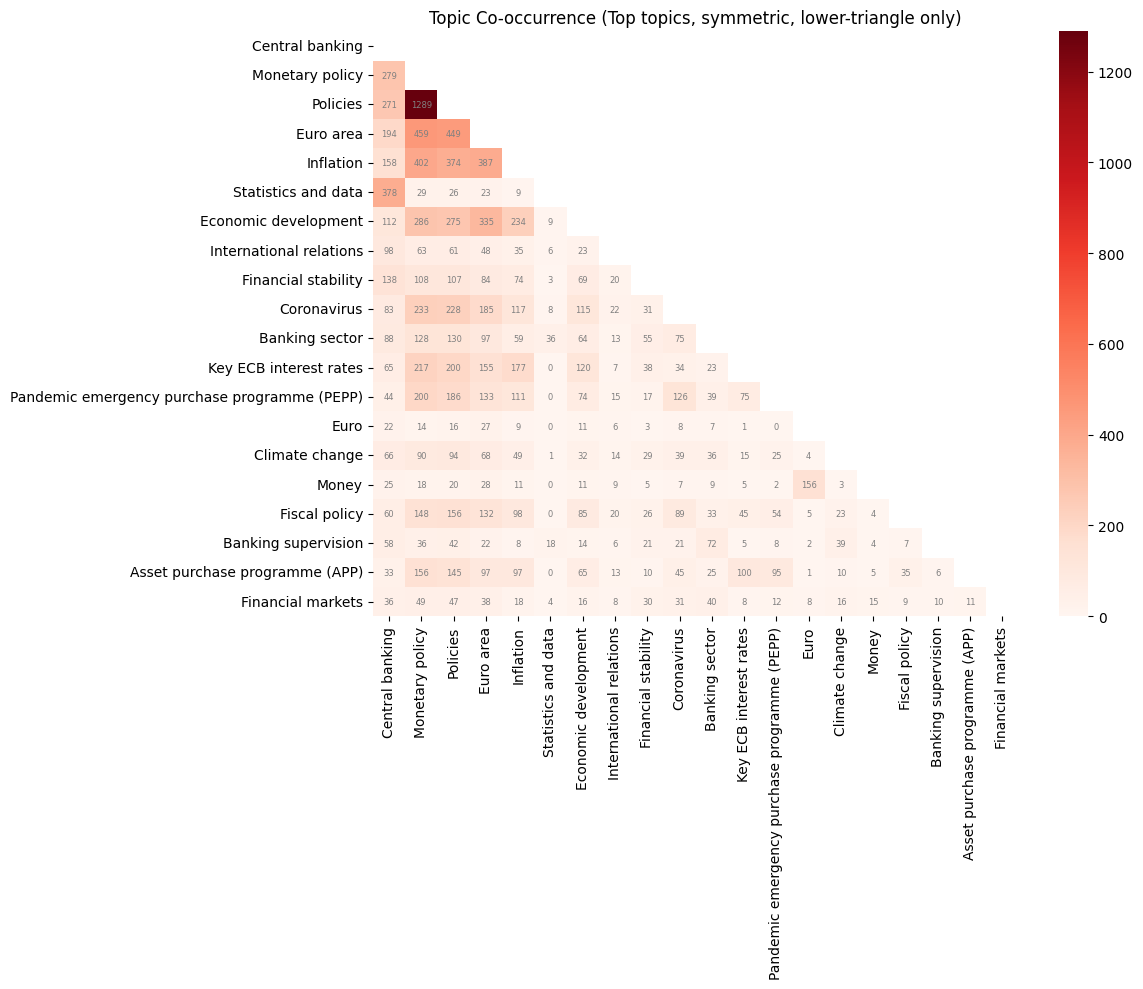

In [8]:
def plot_topic_cooccurrence(df, topic_col, top_topics):
    import itertools
    import numpy as np
    co_occ = []
    for row in df.iter_rows(named=True):
        tlist = [t for t in row[topic_col] if t in top_topics] if row[topic_col] else []
        for a, b in itertools.combinations(sorted(set(tlist)), 2):
            co_occ.append((a, b))
    co_df = pl.DataFrame(co_occ, schema=["t1", "t2"])
    co_df = pl.concat([co_df, co_df.select(pl.col("t2").alias("t1"), pl.col("t1").alias("t2"))])
    counts = co_df.group_by(["t1","t2"]).len().rename({"len": "count"})
    grid = (
        pl.DataFrame({"t1": top_topics})
        .join(pl.DataFrame({"t2": top_topics}), how="cross")
    )
    co_mat = (
        grid.join(counts, on=["t1","t2"], how="left")
        .with_columns(pl.col("count").fill_null(0))
        .pivot(values="count", index="t1", columns="t2")
        .fill_null(0)
        .select(["t1"] + top_topics)
    )
    mat = co_mat.drop("t1").to_numpy()
    ticks = co_mat["t1"].to_list()
    mask = np.triu(np.ones_like(mat, dtype=bool))
    plt.figure(figsize=(12,10))
    sns.heatmap(
        mat,
        cmap="Reds",
        xticklabels=ticks,
        yticklabels=ticks,
        annot=True,
        fmt="d",
        annot_kws={"size": 6, 'color': 'grey'},
        mask=mask
    )
    plt.title("Topic Co-occurrence (Top topics, symmetric, lower-triangle only)")
    plt.tight_layout()
    plt.show()

plot_topic_cooccurrence(df, topic_col, top_topics)

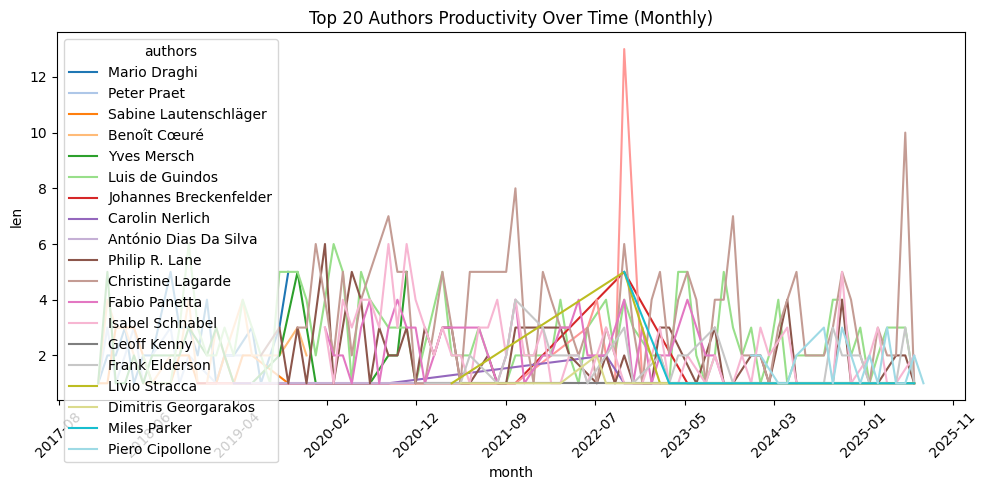

In [9]:
def plot_authors_productivity_over_time(df, top_authors):
    df_exploded = explode(df, "authors")
    df_exploded = df_exploded.filter(pl.col("authors").is_in(top_authors))
    df_monthly = aggregate_by_month(df_exploded, date_col='date', group_cols=['authors'])
    pdf = df_monthly.to_pandas()
    pdf['month'] = pd.to_datetime(pdf['month'], format='%Y-%m')
    plt.figure(figsize=(10,5))
    ax = sns.lineplot(
        data=pdf, 
        x="month", 
        y="len", 
        hue="authors", palette=sns.color_palette('tab20', n_colors=len(top_authors)))
    plt.title("Top 20 Authors Productivity Over Time (Monthly)")
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_authors_productivity_over_time(df, top_authors)


In [11]:
len(list(set([x for z in df['filter_value'] for x in z])))

# df

102